# AutoBuild Conversable Agents: Task Solving with Provided Tools as Functions

In this notebook, we demonstrate how `AssistantAgent` and `UserProxyAgent` agents generated in `AgentBuilder.build()` can make function calls. Here we pass all the functions to be registered with agents into an array `list_of_functions` as a parameter to `build()`. The LLM will automatically determine the appropriate function to register with the Agents.

## Requirement

AutoBuild require `pyautogen[autobuild]`, which can be installed by the following command:

In [ ]:
%pip install pyautogen[autobuild]

## Step 1: Prepare configuration and some useful functions
Prepare a `config_file_or_env` for assistant agent to limit the choice of LLM you want to use in this task. This config can be a path of json file or a name of environment variable.

In [1]:
from IPython import get_ipython
from typing_extensions import Annotated

import autogen
from autogen.agentchat.contrib.agent_builder import AgentBuilder

config_file_or_env = "OAI_CONFIG_LIST"

config_list = autogen.config_list_from_json(config_file_or_env, filter_dict={"model": ["gpt-4-1106-preview", "gpt-4"]})

llm_config = {
    "config_list": config_list,
    "timeout": 120,
}


def start_task(execution_task: str, agent_list: list):
    group_chat = autogen.GroupChat(agents=agent_list, messages=[], max_round=12)
    manager = autogen.GroupChatManager(groupchat=group_chat, llm_config={"config_list": config_list})
    agent_list[0].initiate_chat(manager, message=execution_task)

## Step 2: Defining Function Calls

Here, we define functions and specify the description of the function. We create `list_of_functions` in the following format:

list_of_functions = [
    {"name": "<name_of_the_function>", "description": "<description_of_function>", "function": <function>},
    ...
]

LLM uses function name, function description, agent name, agent description to determine appropriate function registration with an agent.

In [2]:
def exec_python(cell: Annotated[str, "Valid Python cell to execute."]) -> str:
    ipython = get_ipython()
    result = ipython.run_cell(cell)
    log = str(result.result)
    if result.error_before_exec is not None:
        log += f"\n{result.error_before_exec}"
    if result.error_in_exec is not None:
        log += f"\n{result.error_in_exec}"
    return log


list_of_functions = [
    {
        "name": "exec_python",
        "description": "run cell in ipython and return the execution result.",
        "function": exec_python,
    }
]

## Step 3: Create a AgentBuilder
Create a `AgentBuilder` with the specified `config_path_or_env`. AgentBuilder will use `gpt-4` in default to complete the whole process, you can specify the `builder_model` and `agent_model` to other OpenAI model to match your task. 
You can also specify an open-source LLM supporting by vLLM and FastChat, see blog for more details.

In [3]:
builder = AgentBuilder(
    config_file_or_env=config_file_or_env, builder_model="gpt-4-1106-preview", agent_model="gpt-4-1106-preview"
)

## Step 4: Specify a building task

Specify a building task with a general description. Building task will help build manager (a LLM) decide what agents should be built.

In [4]:
building_task = "Draw two agents chatting with each other with an example dialog using matplotlib."

## Step 5: Build group chat agents
Use `build()` to let build manager (the specified `builder_model`) complete the group chat agents generation. Pass the `list_of_functions` to `build()`. To let functions get registered to the agents.

In [5]:
agent_list, agent_configs = builder.build(building_task, llm_config, list_of_functions)

==> Generating agents...
['matplotlib_visual_designer', 'dialog_content_creator', 'python_matplotlib_developer'] are generated.
==> Generating system message...
Preparing system message for matplotlib_visual_designer
Preparing system message for dialog_content_creator
Preparing system message for python_matplotlib_developer
==> Generating description...
Preparing description for matplotlib_visual_designer
Preparing description for dialog_content_creator
Preparing description for python_matplotlib_developer
==> Creating agents...
Creating agent matplotlib_visual_designer with backbone gpt-4-1106-preview...


/home/vscode/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Creating agent dialog_content_creator with backbone gpt-4-1106-preview...
Creating agent python_matplotlib_developer with backbone gpt-4-1106-preview...
Adding user console proxy...
==> Mapping functions with Agents
Function exec_python is mapped to python_matplotlib_developer agent.


## Step 6: Execute task
Let agents generated in `build()` to complete the task collaboratively in a group chat.

User_console_and_code_interpreter (to chat_manager):

Draw two agents chatting with each other with an example dialog using matplotlib.

--------------------------------------------------------------------------------
python_matplotlib_developer (to chat_manager):

***** Suggested tool call (call_Nz8UGiRqterWwQJAe5vuSCt4): exec_python *****
Arguments: 
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_chat_agents():
    fig, ax = plt.subplots()

    # Agent 1 bubble
    agent1_bubble = patches.FancyBboxPatch(
        (0.2, 0.5), 0.2, 0.1,
        boxstyle="round,pad=0.1",
        fc="lightblue",
        ec="blue"
    )
    
    # Agent 2 bubble
    agent2_bubble = patches.FancyBboxPatch(
        (0.6, 0.7), 0.2, 0.1,
        boxstyle="round,pad=0.1",
        fc="lightgreen",
        ec="green"
    )

    ax.add_patch(agent1_bubble)
    ax.add_patch(agent2_bubble)

    # Agent 1 text
    plt.text(0.2, 0.55, "Hello!", ha="center", va="center", fontsize=12)

 

User_console_and_code_interpreter (to chat_manager):



--------------------------------------------------------------------------------
python_matplotlib_developer (to chat_manager):

***** Suggested tool call (call_JAqBFdGQU0OSz7zp0VoA5xP1): exec_python *****
Arguments: 
{
  "cell": "import matplotlib.pyplot as plt\nimport matplotlib.patches as patches\n\n# Define a figure and axis\ndef draw_chat_agents():\n    fig, ax = plt.subplots()\n\n    # Create speech bubbles as patches\n    bubble1 = patches.FancyBboxPatch((0.2, 0.6), 0.5, 0.1,\n                                     boxstyle=\"round,pad=0.1\", fc=\"lightblue\")\n    bubble2 = patches.FancyBboxPatch((0.5, 0.3), 0.5, 0.1,\n                                     boxstyle=\"round,pad=0.1\", fc=\"pink\")\n    ax.add_patch(bubble1)\n    ax.add_patch(bubble2)\n\n    # Add text to the speech bubbles\n    plt.text(0.45, 0.65, \"Hello, how are you?\", ha='center', va='center')\n    plt.text(0.75, 0.35, \"I'm fine, thanks!\", ha='center', 

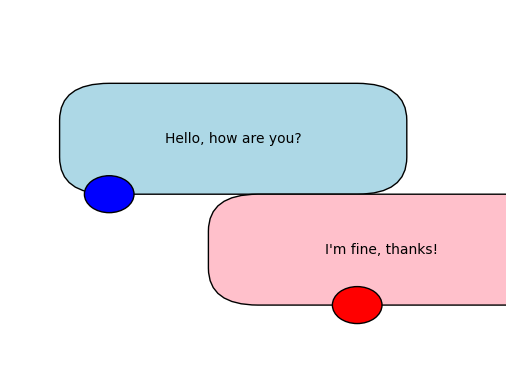

User_console_and_code_interpreter (to chat_manager):

User_console_and_code_interpreter (to chat_manager):

***** Response from calling tool (call_JAqBFdGQU0OSz7zp0VoA5xP1) *****
None
**********************************************************************

--------------------------------------------------------------------------------
matplotlib_visual_designer (to chat_manager):

I have created a static image representation of two agents chatting using matplotlib in Python. Each agent has a colored speech bubble, representing a piece of their conversation.

Here is the visual representation of the conversation:

- Agent 1 (blue) says, "Hello, how are you?"
- Agent 2 (red) replies, "I'm fine, thanks!"

This is the chat visualization that I have built based on the input provided. 

If you require any additional changes or another type of visualization, please let me know!

--------------------------------------------------------------------------------
dialog_content_creator (to chat_ma

In [7]:
start_task(execution_task=building_task, agent_list=agent_list)

## Step 7 (Optional): Clear all agents and prepare for the next task
You can clear all agents generated in this task by the following code if your task is completed or the next task is largely different from the current task. If the agent's backbone is an open-source LLM, this process will also shut down the endpoint server. If necessary, you can use `recycle_endpoint=False` to retain the previous open-source LLMs' endpoint server.

In [8]:
builder.clear_all_agents(recycle_endpoint=True)

All agents have been cleared.


## Step 8: Save & load configs

You can save all necessary information of the built group chat agents.

In [9]:
saved_path = builder.save()

Building config saved to ./save_config_673a2266713feeb3b23fbd5a9b1c714f.json


Here is a case for those agents generated in the above task

```json
{
    "building_task": "Draw two agents chatting with each other with an example dialog using matplotlib.",
    "agent_configs": [
        {
            "name": "matplotlib_visual_designer",
            "model": "gpt-4-1106-preview",
            "system_message": "You are now in a group chat. You need to complete a task with other participants. As a matplotlib_visual_designer, your role is to create visual representations using matplotlib in Python. Your ability to draw and annotate figures with code is your key contribution within the group.\n\nWhen the task requires visual elements such as graphs, plots, or any other form of data visualization, utilize your expertise in Python and matplotlib to execute the necessary commands and produce the desired output. If additional information is needed, utilize matplotlib's documentation or other Python libraries to retrieve it.\n\nIf the task's objective is to create an illustrative example of two agents chatting, use your creativity and design skills to generate an engaging and informative static image that includes example dialogues. Ensure the visuals clearly convey the interaction between the agents.\n\nShould you encounter an issue with the code or output, or if something is unclear in the instructions provided in the chat, do not hesitate to express your concerns or ask for clarification. If confusion persists, seek assistance from the group chat manager, who can offer guidance or designate another participant to help.\n\nIn performing your duties, you will not need to provide code for execution. Your focus should be on the visualization aspect, providing clear, communicative designs as final images. Collaborate with your peers in the chat by sharing your insights, and when you believe the task has been completed to satisfaction, reply with \"TERMINATE.\" Your contributions should always aim to meet the visual communication needs of the group in the context of the task assigned.",
            "description": "The matplotlib_visual_designer is an expert in data visualization using Python's matplotlib library, with a keen eye for aesthetic design and the ability to translate complex data into clear, engaging, and accurate graphical representations. They must be skilled in troubleshooting visual issues and improving the clarity of existing matplotlib code within the context of a group chat setting. This role requires a solid foundation in Python programming, specifically in relation to creating and refining plots and charts through matplotlib."
        },
        {
            "name": "dialog_content_creator",
            "model": "gpt-4-1106-preview",
            "system_message": "You are now a member of a creative team taking on the role of a dialog_content_creator. In this position, your primary responsibility is to craft engaging and natural dialogues between characters for various scenarios, including visual representations such as comic strips or storyboards, with today's task focusing on the use of matplotlib for illustrations.\n\nAs part of your duties, you will:\n\n1. Use your exceptional language skills to generate witty, realistic, and relevant dialogues between characters that suit the context of the illustration or story you are working on.\n\n2. Transform these dialogues into visual formats that can be easily understood and appreciated by an audience. This may involve plotting text and characters using tools such as matplotlib in Python.\n\n3. Ensure the visual elements align with the intended message and the dialogue flows naturally, enhancing the overall storytelling experience.\n\n4. Assess the effectiveness of the dialogues and illustrations, being open to doubts or questions regarding the content you've created. Your critical thinking will help refine and perfect the conversation for the final output.\n\n5. Keep in mind that coding skills in Python will be useful to execute specific tasks related to the visual representation of your dialogues. However, the core focus remains on your content creation capabilities.\n\nIf you encounter challenges or ambiguities in the process, do not hesitate to reach out for support and clarification from the group chat manager or other team members. Collaboration is key, and alternate perspectives can be invaluable when creating the best content possible.\n\nOnce your task is completed to your satisfaction, confirm its completion with a \"TERMINATE\" message. This signals that you have successfully met the user's needs and the project objectives have been accomplished.",
            "description": "The Dialog Content Creator is a dynamic and vigilant communicator, adept at crafting engaging dialogue with a keen eye for reviewing and improving upon the flow of conversation within a group chat. They should possess strong language and editing skills, as well as the ability to critically analyze the context to identify inaccuracies or ambiguities in previous messages, intervening when necessary to clarify or correct the dialogue. If the role requires engaging with Python code, they should be proficient in reading and understanding Python scripts to verify and rectify any issues, ensuring the interaction remains accurate and informative."
        },
        {
            "name": "python_matplotlib_developer",
            "model": "gpt-4-1106-preview",
            "system_message": "You are now in a group chat. You need to complete a task with other participants. As a python_matplotlib_developer, you will use your expertise in Python and Matplotlib to visualize data and potentially create complex plots. You will be given tasks that relate to data visualization or graphical representation of data using Matplotlib. When you need to present information or data visualization, accomplish this by writing Python code utilizing the Matplotlib library to render images, graphs, or diagrams. Ensure all tasks involving code are performed in Python, with clear instructions on the completion of the task provided alongside.\n\nFor cases where you need to gather information or every time a new stage of the task is initiated, clearly articulate the information being sought or the step being embarked upon. If any issues arise, such as an absence of output after executing the code or encountering errors, you are encouraged to question the previous messages or code in the group chat and provide an updated solution. If at any point you face uncertainty, request assistance from the group chat manager who will provide guidance or assign the task to another participant.\n\nPlease remember that as a python_matplotlib_developer, your role is focused on coding in Python, primarily using Matplotlib for creating visualizations. If a task requires your response or completion, present this using Python code and ensure you deliver the full details of implementation instead of partial code snippets. Avoid multitasking within a single response, keep your instructions clear, and adhere to the group chat's guidance and flow.\n\nWhenever you finalize a task, or if you deem the completion of a task to be satisfactory, confirm with the group by stating \"TERMINATE\".",
            "description": "The python_matplotlib_developer is a proficient Python coder with in-depth knowledge of the Matplotlib library, adept at data visualization, debugging code, and providing accurate graphical representations. This individual should be able to confidently critique and suggest corrections for Python Matplotlib code, ensuring that outputs are valid and effectively communicated. In a group chat, the python_matplotlib_developer can offer insights and fixes when there are issues with code execution or when data visualizations need to be optimized or corrected."
        }
    ],
    "coding": true,
    "default_llm_config": {
        "timeout": 120
    },
    "code_execution_config": {
        "last_n_messages": 2,
        "work_dir": "groupchat",
        "use_docker": false,
        "timeout": 60
    }
}
```